In [1]:
import torch
import torch.nn.functional as F
import random

In [2]:
with open('names.txt', 'r') as f:
    words = [word.strip() for word in f]
# get unique chars
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
sz = len(stoi.items())

In [3]:
def build_set(words, block_size):
    X, Y = [], []
    for word in words:
        context = [0] * block_size  
        for ch in word + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [4]:
random.shuffle(words)
train_bound = int(0.8 * len(words))
val_bound = int(0.9 * len(words))
train_set = words[:train_bound]
val_set = words[train_bound:val_bound]
test_set = words[val_bound:]

In [5]:
block_size = 4
X_tr, Y_tr = build_set(train_set, block_size)
X_val, Y_val = build_set(val_set, block_size)
X_test, Y_test = build_set(test_set, block_size)

In [6]:
X_tr.shape, Y_tr.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([182320, 4]),
 torch.Size([182320]),
 torch.Size([22922, 4]),
 torch.Size([22922]),
 torch.Size([22904, 4]),
 torch.Size([22904]))

In [14]:
# initialize hyperparameters
hidden_layer_count = 200
emb_dim = 10
iterations = 100000
lre = 0.1
batch_sz = 100

Follows this network but with characters instead of words  
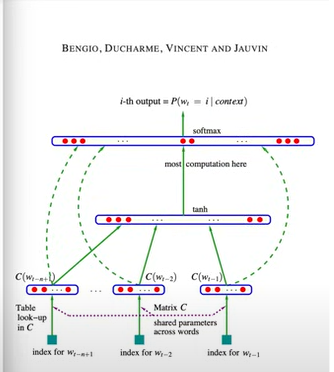

In [36]:
# initialize network parameters
C = torch.randn(sz, emb_dim)
# multiplied with C[x], which will have dimensions training_examples x block_size x emb_dim
# good practice to have capital letters for matrices
W1 = torch.randn(block_size * emb_dim, hidden_layer_count)
b1 = torch.randn(hidden_layer_count)
# drastically reducing weights and biases to achieve uniform distribution on initial prediction
W2 = torch.randn(hidden_layer_count, sz) * 0.1
b2 = torch.randn(sz) * 0.01
# this will broadcast into num_examples, which makes sense, one for each example
bngain = torch.ones((1, hidden_layer_count))
bnbias = torch.zeros((1, hidden_layer_count))
# initial Gaussian distribution
bnmean_r = torch.zeros((1, hidden_layer_count))
bnstd_r = torch.ones((1, hidden_layer_count))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]

In [37]:
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

14297

In [38]:
for i in range(iterations):

    # get minibatch
    idxes = torch.randint(0, X_tr.shape[0], (batch_sz, ))

    # forward pas
    emb = C[X_tr[idxes]]
    # lets batch norm this layer instead of Kaiming init
    hlin = emb.view(-1, block_size * emb_dim) @ W1 + b1

    # across the batch of examples i.e column                
    hmean = hlin.mean(0, keepdim = True)
    hstd = hlin.std(0, keepdim = True)
    hlin = bngain * (hlin - hmean) / hstd + bnbias

    with torch.no_grad():
        bnmean_r = 0.99*bnmean_r + 0.01*hmean
        bnstd_r = 0.99*bnstd_r + 0.01*hstd        
    h = torch.tanh(hlin)
    logits = h @ W2 + b2
    # this automatically computes softmax under the hood
    loss = F.cross_entropy(logits, Y_tr[idxes])

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    current_lr = lre if i < iterations / 4 else 0.1*lre
    for p in parameters:
        p.data += -current_lr * p.grad

    if i % 10000 == 0:
        print(f"{i} / {iterations}: {loss.data}")

0 / 100000: 3.7792816162109375
10000 / 100000: 2.261338233947754
20000 / 100000: 2.007660388946533
30000 / 100000: 2.116248607635498
40000 / 100000: 1.8947960138320923
50000 / 100000: 2.0788424015045166
60000 / 100000: 2.122727155685425
70000 / 100000: 2.0328149795532227
80000 / 100000: 2.3060085773468018
90000 / 100000: 1.9855449199676514


In [39]:
@torch.no_grad
def get_loss(X, Y):
    emb = C[X]
    hlin = emb.view(-1, block_size * emb_dim) @ W1 + b1
    hlin = bngain * (hlin - bnmean_r) / bnstd_r + bnbias
    h = torch.tanh(hlin)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

In [40]:
# use complete training set
get_loss(X_tr, Y_tr)

tensor(2.1300)

In [41]:
# use complete validation set
get_loss(X_val, Y_val)

tensor(2.1491)

In [28]:
# sampling, my favourite!

for _ in range(10):

    outvec = []
    context = [0] * block_size
    idx = 0
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
      context = context[1:] + [idx]
      outvec.append(idx)
      if idx == 0:
          break
    print(''.join(itos[idx] for idx in outvec))
    

cenni.
evana.
elisareni.
dusle.
owdy.
minh.
avaby.
kathen.
ayen.
hisania.
